# Investigating Fandango Movie Ratings

## Is Fandango Still Inflating Ratings?

### In October 2015, a data journalist names Walt Hickey analysed movie ratings data from the Randango website. The results of this analysis was a finding of bias and dishonesty based on poor data evaluation. 

#### If interested the article can be found here: https://fivethirtyeight.com/features/fandango-movies-ratings/

### The issues found were as follows:
#### - The actual rating was almost always rounded up to the nearest half-star. For example a movie rating of 4.1 would be rounded not to 4, but 4.5 stars.
#### - For 8% of the ratings analysed, the rounding was done to the nearest whole star. For example a 4.5 star rating would be rounded to 5.
#### - For one movie rating, the rounding off was completely bizarre, a rating of 4 in the HTML would be displated as a 5 star rating.

### What will my project address?
#### After Mr Hickeys publication, Fandango officials replied saying the bias was unintentional and a result of a bug in their system
#### My project will test whether this bug has been fixed since the reply, and whether the Fandango analysis has changed since Hickeys publication. The actual rating however has since been removed from the HTML, as such I will use recent movie ratings data to determine the changes supposedly made by Fandango.

### Initial Data Analysis and Preparation

#### There are two sources of data I have found, the data collected by Hickey made available on GitHub before his analysis. Another was scraped by a DataQuest employee and was again made publically available on GitHub, this was recorded after the publication in 2017.

#### Fandango Comparison: https://github.com/fivethirtyeight/data/tree/master/fandango

#### Movie Ratings 2017:                                                                                                    https://github.com/mircealex/Movie_ratings_2016_17

In [59]:
import pandas as pd
import numpy as np

FComp = pd.read_csv('fandango_score_comparison.csv')
MRatings = pd.read_csv('movie_ratings_16_17.csv')

In [60]:
FComp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
FILM                          146 non-null object
RottenTomatoes                146 non-null int64
RottenTomatoes_User           146 non-null int64
Metacritic                    146 non-null int64
Metacritic_User               146 non-null float64
IMDB                          146 non-null float64
Fandango_Stars                146 non-null float64
Fandango_Ratingvalue          146 non-null float64
RT_norm                       146 non-null float64
RT_user_norm                  146 non-null float64
Metacritic_norm               146 non-null float64
Metacritic_user_nom           146 non-null float64
IMDB_norm                     146 non-null float64
RT_norm_round                 146 non-null float64
RT_user_norm_round            146 non-null float64
Metacritic_norm_round         146 non-null float64
Metacritic_user_norm_round    146 non-null float64
IMDB_norm_round               146 n

In [61]:
MRatings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
movie           214 non-null object
year            214 non-null int64
metascore       214 non-null int64
imdb            214 non-null float64
tmeter          214 non-null int64
audience        214 non-null int64
fandango        214 non-null float64
n_metascore     214 non-null float64
n_imdb          214 non-null float64
n_tmeter        214 non-null float64
n_audience      214 non-null float64
nr_metascore    214 non-null float64
nr_imdb         214 non-null float64
nr_tmeter       214 non-null float64
nr_audience     214 non-null float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


#### Create new DataFrames containing only the columns that we need.
##### To create these I could use .loc, but as I am creating a copy anyway I can just use indexing on the full dataset.

In [62]:
BefPublic = FComp[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
AftPublic = MRatings[['movie', 'year', 'fandango']].copy()

##### According to the README.md file in the repository, the Hickey dataset was a selection of the fullest rows of data found in Fandango in mid 2015, the new dataset contains the only the most popular movies released in 2016 and 2017. 
##### This is not a random sample of data and it will be skewed by popularity and fullness, along with release date issues. There is therfore a strong chance that these datasets will not be representative of the entire movie population.
##### The options after discovering this issue are thus:
##### 1. Find a new cleaner and fuller dataset to work with and fits our purpose criteria.
##### 2. Continue with this dataset but slightly alter our goal to provide a conclusion for only popular movies that Fandango displayed in 2015 and 2016.

### New Goal: Is there a difference between Fandangos ratings of popular movies between 2015 and 2016?
#### We now need to isolate the samples we want to use for the analysis.

In [63]:
AftPublic.sample(n = 10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


##### Here I should check and remove any unpopular movies from the old dataset, this will make both of my datasets for the popularity constraint placed on the newer data. I can do this by looking for movies with less than ~30 fan ratings.

In [64]:
sum(BefPublic['Fandango_votes'] < 30)

0

##### Luckily for me there are no unpopular movies in the old dataset, so now I can isolate the sample points belonging to my population of interest. In this case this means separating the movies in the old dataset into two different datasets, one for 2015 and another for 2016.
##### Unfortunately there is no release date column containing a year, however the FILM column has the year in brackets, we can strip this and add it to a new column. I need the last 5 elements of the string excluding the end bracket character.

In [65]:
BefPublic['Year'] = BefPublic['FILM'].str[-5:-1]
BefPublic.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


In [66]:
BefPublic['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

##### We need to remove the films from 2014

In [69]:
fandango_2015 = BefPublic[BefPublic['Year'] == '2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

##### Now to do the same with the data from after the publication, this should be easier as there is a year column

In [70]:
AftPublic['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

##### Here we need to make a tweak as this column is an int64 datatype not a string

In [72]:
fandango_2016 = AftPublic[AftPublic['year'] == 2016]
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

### Start Comparison

#### The aim here is to compare the ratings from 2015 and 2016, to do this I will use a Kernel Density Estimation plot and place the distributions on the same figure.

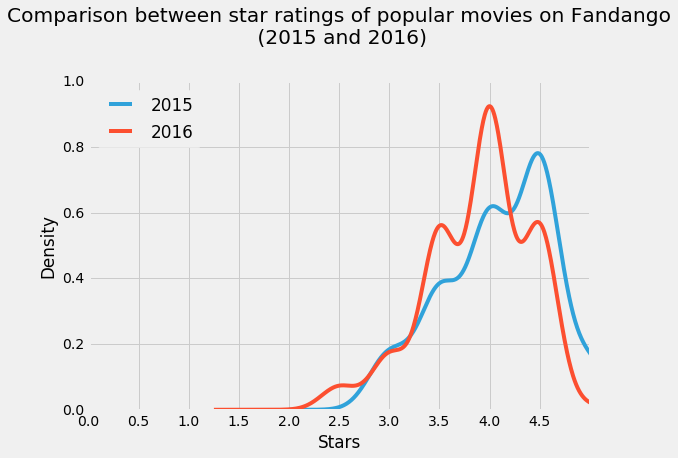

In [88]:
# I will need pyplot from the matplotlib library for this plot
# I also plan to have ticks on my plot, for which I can use arange
# from the numpy library
# I'll need to use the magic function %matplotlib inline to display
# the plot in Jupyter
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline

plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title('Comparison between star ratings of popular movies on Fandango\n (2015 and 2016)', y = 1.1)
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0, 5, .5))
plt.show()


#### From this data we can conclude:
#### - Both sets of data are left skewed, this makes sense as the data constraints called for popular movies only.
#### - The 2016 dataset is much more Gaussian than the 2015 data, this also implies that the bug has been fixed as ratings are more balanced. The 2016 data has a much lower average than the 2015 set, suggesting that the rounding up issue has been fixed.
#### The definite conclusions we can draw from this figure are that 2016 movies were rated lower on average than 2015 movies and that there is definetely a change between Fandangos star rating for popular movies between 2015-16.

#### It would be interesting to investigate the popularity distribution for the entire population and not just the popular movies, the left skewed nature of these sets imply that in general movies are well rated in Fandango. This could be an good topic for a future project.


### Comparing Relative Frequencies
#### There is a clear difference between the distributions, the 2016 movies were rated slightly lower than the 2015 movies.
#### While comparing with a distribution plot was a good start, it may also be useful to study more granular information.

In [93]:
print('2015' + '\n' + '-' * 15)
# Make a frequency distribution for the 2015 data, I want 
# percentages so I'll turn on normalisation and * by 100
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

2015
---------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [94]:
print('2016' + '\n' + '-' * 15)
# Make a frequency distribution for the 2016 data
fandango_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2016
---------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

#### The difference is still just as apparent from the frequency tables, the most frequent star rating went form 4.5 in 2015 to 4 in 2016, the 2.5 star value was also added in 2016, and the 5 star rating was reduced to 0.5%. It is still obvious that the 2016 movies have lower star ratings than the 2015 movies.

### Determining the Direction of the Change
#### The difference from the frequency tables are not as apparent as the diifference as seen in the Kernel plots. If I take a more statistical approach I can get a more precise picture of the direction of the difference. 
#### I'll take each distribution of movie ratings and compute the mean, median and mode, then compare these statistics to see what they can tell me.

In [113]:
# Compute Statistics
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

# For some reason the .mode() method returns the type
mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

# Summarise in a dataframe
summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


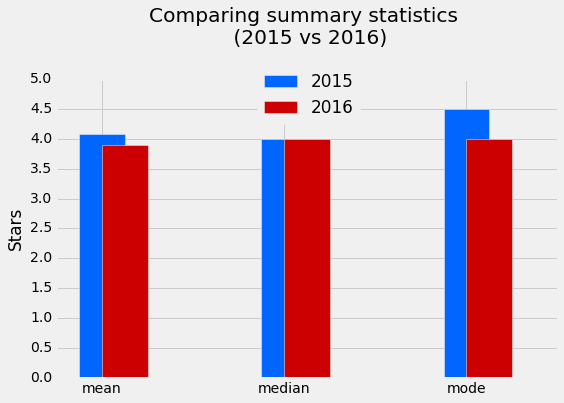

In [128]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics \n (2015 vs 2016)', y = 1.1)
plt.ylim(0,5)
plt.yticks(arange(0,5.1,0.5))
plt.ylabel('Stars')
plt.legend(framealpha = True, loc = (0.4,0.85))



#### The mean and mode were both lower in 2016 than 2015, by about 0.2 in the mean and a full 0.5 in the mode. The median stayed the same between 2015-16.
#### This plot reinforces our theory that the bugs have been fixed, the lower mean and mode imply that movies have ceased to be round up and have instead been given the correct ratings.